In [1]:
import sys
from pathlib import Path
import csv
import math
from typing import Any, Callable, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure path to data_handling is correct
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_consolidate/xxz_ring_16/measurements


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim

        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))

    def forward(self, cond: torch.Tensor):
        # Handle shape (B, D) or (D,)
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)

        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)

        N, H = self.num_visible, self.num_hidden
        gamma_b, beta_b, gamma_c, beta_c = torch.split(x, [N, N, H, H], dim=-1)
        return gamma_b, beta_b, gamma_c, beta_c


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        # CRITICAL: Smaller init std (0.01) often stabilizes training compared to 0.1
        nn.init.normal_(self.W, mean=0.0, std=0.01)

        self.conditioner = Conditioner(num_visible=num_visible, num_hidden=num_hidden,
                                       cond_dim=cond_dim, hidden_width=conditioner_width)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        # Broadcasting logic matching your working script
        if b.dim() == 1:
            b = b.unsqueeze(0).expand_as(v)

        h_arg = v @ W
        if c.dim() == 1:
            c = c.unsqueeze(0).expand(h_arg.shape[0], -1)

        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(h_arg + c).sum(dim=-1)
        return term1 - term2

    @staticmethod
    def _sample_bernoulli(probs: torch.Tensor, gen: torch.Generator) -> torch.Tensor:
        noise = torch.rand(probs.shape, generator=gen, device=probs.device, dtype=probs.dtype)
        return (noise < probs).to(probs.dtype)

    def _gibbs_step_T(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, gen: torch.Generator):
        # Sample h | v
        logits_h = (v @ self.W + c_mod) / T
        p_h = torch.sigmoid(logits_h)
        h = self._sample_bernoulli(p_h, gen)

        # Sample v | h
        logits_v = (h @ self.W.t() + b_mod) / T
        p_v = torch.sigmoid(logits_v)
        v = self._sample_bernoulli(p_v, gen)
        return v

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        values, _, cond = batch

        gen: torch.Generator = aux_vars.get("gen", torch.Generator(device='cpu'))
        l2_strength: float = float(aux_vars.get("l2_strength", 0.0))

        v_data = values.float().to(self.W.device)
        cond = cond.to(self.W.device, dtype=torch.float32)

        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c

        l2_reg = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        # CD-k: Start from random noise (Mixes better than starting from data usually)
        v_model = (torch.rand(v_data.shape, generator=gen, device=v_data.device) < 0.5).float()

        for _ in range(self.k):
            v_model = self._gibbs_step_T(v_model, b_mod, c_mod, self.T, gen)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)
        fe_delta = fe_data - fe_model

        loss = fe_delta.mean() + l2_strength * l2_reg

        return loss, {
            "free_energy_mean": fe_delta.mean().detach(),
            "free_energy_std": fe_delta.std(unbiased=False).detach()
        }

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, gen: torch.Generator) -> torch.Tensor:
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)
        cond = cond.to(next(self.parameters()).device, dtype=torch.float32)

        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c

        B = cond.shape[0]
        v = (torch.rand((B, self.num_visible), generator=gen, device=cond.device) < 0.5).float()

        if T_schedule.dim() == 0:
            T_schedule = T_schedule.view(1)

        for i in range(int(T_schedule.shape[0])):
            T_i = float(T_schedule[i].item())
            v = self._gibbs_step_T(v, b_mod, c_mod, T_i, gen)

        return v

In [3]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux

def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int,
          gen: torch.Generator, l2_strength: float, lr_schedule_fn: Callable[[int], float]):
    metrics: Dict[int, Any] = {}
    global_step = 0

    print(f"{'Epoch':<6} | {'Loss':<9} | {'FE Mean':<9} | {'FE STD':<9} | {'LR':<9}")
    print("-" * 55)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean_last = torch.tensor(0.0)
        fe_std_last = torch.tensor(0.0)

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups: g["lr"] = lr

            aux_vars = { "gen": gen, "l2_strength": l2_strength }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_mean_last = aux_out.get("free_energy_mean", torch.tensor(0.0))
            fe_std_last = aux_out.get("free_energy_std", torch.tensor(0.0))
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))

        metrics[epoch] = dict(loss=avg_loss, free_energy_mean=float(fe_mean_last), lr=lr_epoch)

        print(f"{epoch + 1:<6} | {avg_loss:+.4f}   | {float(fe_mean_last):+.4f}    | "
              f"{float(fe_std_last):.4f}    | {lr_epoch:.5f}")

    return model, metrics

def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None: center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

In [5]:
CHAIN_LENGTH = 16
FILE_SAMPLES = 5_000_000
TRAIN_SAMPLES = 50_000

delta_support = [0.50, 1.00, 2.00]
file_names = [f"xxz_{CHAIN_LENGTH}_delta{d:.2f}_{FILE_SAMPLES}.npz" for d in delta_support]
file_paths = [data_dir / fn for fn in file_names]
samples_per_file = [TRAIN_SAMPLES] * len(file_paths)

print(f"System: XXZ Chain {CHAIN_LENGTH}")
for fp in file_paths:
    if not fp.exists(): print(f"WARNING: File not found: {fp}")

# Load using load_measurements_npz (not txt)
ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["delta"], samples_per_file=samples_per_file)

print(f"Values shape: {tuple(ds.values.shape)}")
print(f"Params shape: {tuple(ds.system_params.shape)}")

System: XXZ Chain 16
Values shape: (150000, 16)
Params shape: (150000, 1)


In [8]:
# Hyperparameters (Matched to working script mostly)
batch_size        = 1024
num_visible       = CHAIN_LENGTH
num_hidden        = 24  # Slightly higher than 16 for XXZ complexity
conditioner_width = 32
num_epochs        = 20 # Usually converges fast
k_steps           = 15  # CD-15
init_lr           = 1e-2
final_lr          = 1e-4
l2_strength       = 0.0

gen = torch.Generator().manual_seed(42)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=gen)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)

print(f"Training on {num_visible} qubits with {num_hidden} hidden units...")
model, metrics = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                       gen=gen, l2_strength=l2_strength, lr_schedule_fn=lr_schedule_fn)

Training on 16 qubits with 24 hidden units...
Epoch  | Loss      | FE Mean   | FE STD    | LR       
-------------------------------------------------------
1      | -0.1069   | -0.1689    | 3.7621    | 0.00663
2      | -0.1128   | -0.5406    | 3.6055    | 0.00646
3      | -0.1898   | -0.1180    | 3.7579    | 0.00630
4      | -0.1437   | -0.4148    | 3.5857    | 0.00612
5      | -0.3001   | -0.4148    | 3.9792    | 0.00595
6      | -0.2561   | -0.1921    | 3.9024    | 0.00577
7      | -0.2837   | -0.0465    | 3.4802    | 0.00559
8      | -0.3252   | -0.2034    | 3.6671    | 0.00541
9      | -0.3071   | -0.1842    | 4.0396    | 0.00523
10     | -0.2734   | -0.3601    | 3.7272    | 0.00505
11     | -0.2690   | +0.0220    | 3.7188    | 0.00487
12     | -0.2891   | -0.4161    | 3.7491    | 0.00469
13     | -0.3069   | -0.0530    | 3.4350    | 0.00451
14     | -0.3372   | -0.4773    | 3.6393    | 0.00433
15     | -0.3640   | -0.5266    | 3.6484    | 0.00415
16     | -0.3624   | -0.1653    |

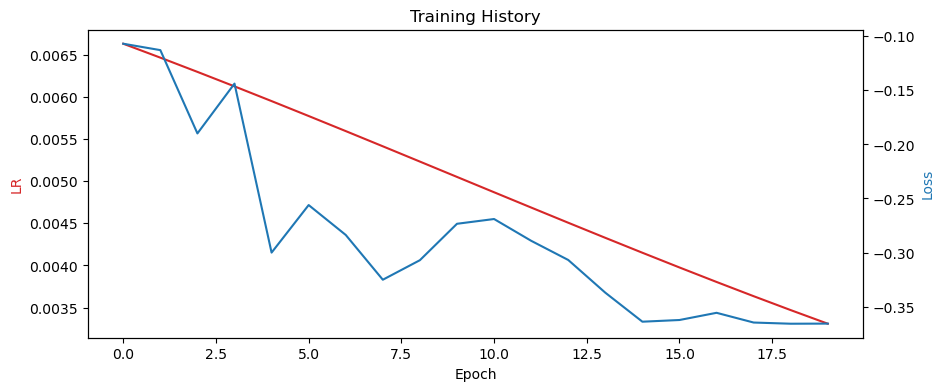

In [9]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(epochs, lr_vals, color="tab:red", label="LR")
ax1.set_ylabel("LR", color="tab:red")
ax1.set_xlabel("Epoch")

ax2 = ax1.twinx()
ax2.plot(epochs, loss_vals, color="tab:blue", label="CD Loss")
ax2.set_ylabel("Loss", color="tab:blue")

plt.title("Training History")
plt.show()

In [10]:
@torch.no_grad()
def compute_renyi_entropy(model: ConditionalRBM, delta: float, max_ell: int, num_samples: int = 10000):
    """
    2nd Renyi Entropy via Simple Replica Trick for subsystem sizes l=1..max_ell.
    Matches the logic of the TFIM script exactly.
    """
    device = next(model.parameters()).device
    model.eval()

    # Create batch of conditions
    cond = torch.full((num_samples, 1), float(delta), device=device, dtype=torch.float32)

    # Pre-calculate biases for this batch (Efficiency)
    gamma_b, beta_b, gamma_c, beta_c = model.conditioner(cond)
    b_mod = (1.0 + gamma_b) * model.b.unsqueeze(0) + beta_b
    c_mod = (1.0 + gamma_c) * model.c.unsqueeze(0) + beta_c

    # Generate two independent replicas
    T_schedule = torch.full((model.k,), model.T, device=device)
    # Use consistent seed for reproducibility
    gen = torch.Generator(device=device).manual_seed(12345)

    s1 = model.generate(cond, T_schedule, gen)
    s2 = model.generate(cond, T_schedule, gen)

    results = []

    # Free Energy of original configurations
    # log_psi = -0.5 * FreeEnergy
    F1 = model._free_energy(s1, model.W, b_mod, c_mod)
    F2 = model._free_energy(s2, model.W, b_mod, c_mod)

    # Denom = log(psi(s1)psi(s2)) = -0.5 * (F1 + F2)
    log_denom = -0.5 * (F1 + F2)

    sys.stdout.write(f"Calculating S2 for Delta={delta}: ")

    for ell in range(1, max_ell + 1):
        # SWAP TRICK
        s1_swap = s1.clone()
        s2_swap = s2.clone()

        # Swap first ell bits (1D chain logic)
        s1_swap[:, :ell] = s2[:, :ell]
        s2_swap[:, :ell] = s1[:, :ell]

        F1_swap = model._free_energy(s1_swap, model.W, b_mod, c_mod)
        F2_swap = model._free_energy(s2_swap, model.W, b_mod, c_mod)

        # Num = log(psi(s1')psi(s2')) = -0.5 * (F1' + F2')
        log_num = -0.5 * (F1_swap + F2_swap)

        log_ratio = log_num - log_denom
        ratio = torch.exp(log_ratio)

        swap_expectation = ratio.mean()

        # Avoid log(0)
        if swap_expectation < 1e-9:
            s2_val = 0.0 # Or appropriate breakdown handling
        else:
            s2_val = -torch.log(swap_expectation).item()

        results.append(s2_val)
        sys.stdout.write(f".")
        sys.stdout.flush()

    print(" Done.")
    return results

In [11]:
delta_eval_values = [0.5, 1.0, 2.0]
max_subsystem = CHAIN_LENGTH // 2 # 8
n_renyi_samples = 20000

rbm_data = {}

for d_val in delta_eval_values:
    s2_curve = compute_renyi_entropy(model, d_val, max_subsystem, n_renyi_samples)
    rbm_data[d_val] = s2_curve

Calculating S2 for Delta=0.5: ........ Done.
Calculating S2 for Delta=1.0: ........ Done.
Calculating S2 for Delta=2.0: ........ Done.


Reference data loaded.


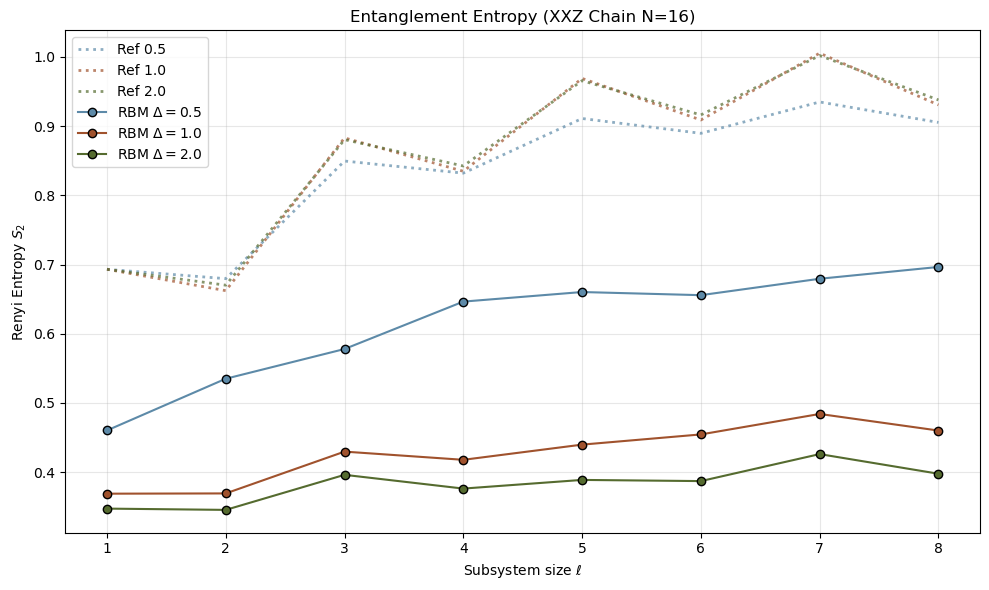

In [12]:
# Load Reference
ref_file = Path(f"xxz_{CHAIN_LENGTH}_entropy_ref.csv")
try:
    df_ref = pd.read_csv(ref_file)
    # Find l columns
    l_cols = sorted([c for c in df_ref.columns if c.startswith("l")], key=lambda s: int(s[1:]))
    l_axis_ref = [int(c[1:]) for c in l_cols]

    ref_curves = {}
    for d in delta_eval_values:
        # Match delta
        row = df_ref.loc[np.isclose(df_ref["delta"], d)].iloc[0]
        ref_curves[d] = row[l_cols].to_numpy()

    print("Reference data loaded.")
except Exception as e:
    print(f"Reference load failed: {e}")
    ref_curves = {}
    l_axis_ref = list(range(1, max_subsystem + 1))


plt.figure(figsize=(10, 6), dpi=100)

styles = {
    0.5: {'color': '#5D8AA8', 'label': r'$\Delta=0.5$'},
    1.0: {'color': '#A0522D', 'label': r'$\Delta=1.0$'},
    2.0: {'color': '#556B2F', 'label': r'$\Delta=2.0$'}
}

# Plot Reference
for d, vals in ref_curves.items():
    c = styles[d]['color']
    # align lengths
    x = l_axis_ref[:len(vals)]
    plt.plot(x, vals, linestyle=':', linewidth=2, color=c, alpha=0.7, label=f"Ref {d}")

# Plot RBM
l_rbm = range(1, max_subsystem + 1)
for d, vals in rbm_data.items():
    s = styles[d]
    plt.plot(l_rbm, vals, marker='o', linestyle='-', color=s['color'],
             markeredgecolor='k', label=f"RBM {s['label']}")

plt.xlabel(r"Subsystem size $\ell$")
plt.ylabel(r"Renyi Entropy $S_2$")
plt.title(f"Entanglement Entropy (XXZ Chain N={CHAIN_LENGTH})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()